In [ ]:
import warnings
from collections.abc import Callable

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from desmin_reconstruction.plotting import clustered_scatterplot
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.preprocessing.storm import (
    align_patch,
    find_optimal_clustering_angle,
)
from hdbscan import HDBSCAN
from jaxtyping import Float
from scipy.spatial.transform import Rotation
from tqdm import tqdm


df = pl.read_csv("../data/results/desmin_alphaactinin_2.5um_filtered.csv")
out = df.partition_by("probe")

In [ ]:
def calibrate_tilt(
    points: Float[np.ndarray, "N 3"],
    sweep_angles: Float[np.ndarray, " N_angles"],
    sweep_angles2: Float[np.ndarray, " N_angles2"],
    *,
    degrees: bool = True,
) -> tuple[
    Callable, tuple[Float[np.ndarray, " N_angles"], Float[np.ndarray, " N_angles"]]
]:
    """Given an array of localization coordiates, sweep over the provided angle range
    to find optimal rotation angles about the y and x axes that minimizes the z range
    of the dataset."""

    def alignment_metric(z):
        z_quantiles = np.quantile(z, (0.25, 0.75))
        return z_quantiles[1] - z_quantiles[0]

    # Note that it is not that difficult to discard the dependency on scipy.spatial,
    # as 3D rotation matrices about x and y axes are quite simple.
    heights_theta = []
    for theta in tqdm(sweep_angles):
        r = Rotation.from_rotvec(theta * np.array([0, 1, 0]), degrees=degrees)
        points_rotated = r.apply(points)
        z = points_rotated[:, 2]
        heights_theta.append(alignment_metric(z))
        # heights_theta.append(np.max(z) - np.min(z))
    theta_opt = sweep_angles[np.argmin(heights_theta)]

    r1 = Rotation.from_rotvec(theta_opt * np.array([0, 1, 0]), degrees=degrees)
    points = r1.apply(points)

    heights_phi = []
    for phi in tqdm(sweep_angles):
        r = Rotation.from_rotvec(phi * np.array([1, 0, 0]), degrees=degrees)
        points_rotated = r.apply(points)
        z = points_rotated[:, 2]
        heights_phi.append(alignment_metric(z))
        # heights_phi.append(np.max(z) - np.min(z))
    phi_opt = sweep_angles[np.argmin(heights_phi)]
    r2 = Rotation.from_rotvec(phi_opt * np.array([1, 0, 0]), degrees=degrees)
    points = r1.apply(points)

    heights_gamma = []
    for gamma in tqdm(sweep_angles2):
        r = Rotation.from_rotvec(gamma * np.array([0, 0, 1]), degrees=degrees)
        points_rotated = r.apply(points)
        x = points_rotated[:, 0]
        heights_gamma.append(alignment_metric(x))
    gamma_opt = sweep_angles2[np.argmin(heights_gamma)]
    r3 = Rotation.from_rotvec(gamma_opt * np.array([0, 0, 1]), degrees=degrees)

    transform = lambda pts: r3.apply(r2.apply(r1.apply(pts)))
    return transform, (
        np.asarray(heights_theta),
        np.asarray(heights_phi),
        np.asarray(heights_gamma),
    )


In [3]:
points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}

In [ ]:
transform, metrics = calibrate_tilt(
    np.concatenate(list(points.values()), axis=0),
    np.arange(-2, 2, 0.001),
    np.arange(-40, 0, 0.1),
)

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:08<00:00, 46.22it/s]


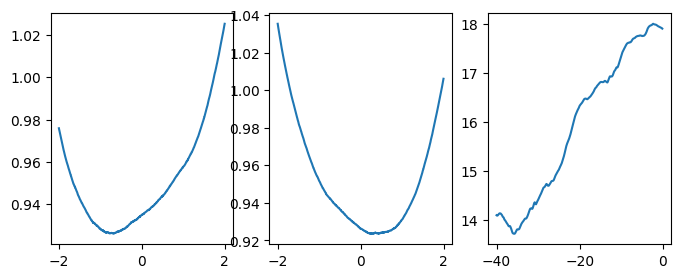

In [8]:
fig, axes = plt.subplots(1, len(metrics), figsize=(8, 3))
x_vals = (np.arange(-2, 2, 0.001), np.arange(-2, 2, 0.001), np.arange(-40, 0, 0.1))
for i, ax in enumerate(axes):
    ax.plot(x_vals[i], metrics[i])

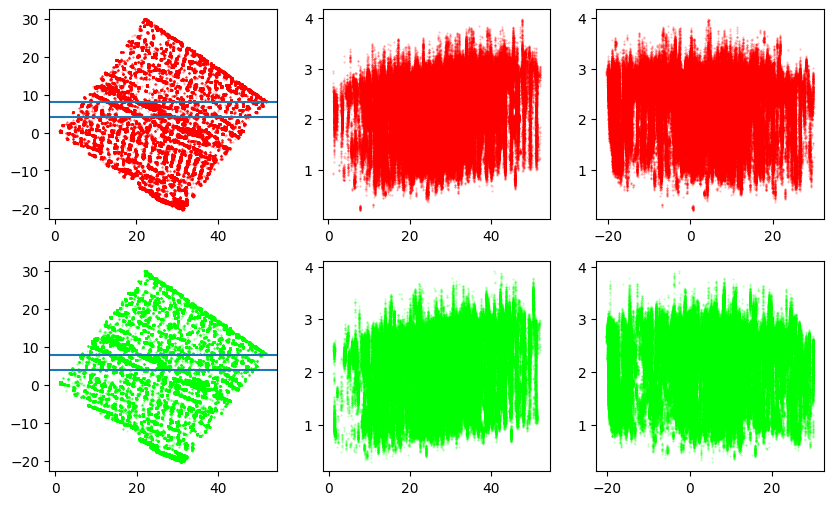

In [10]:
points_final = {k: transform(v) for k, v in points.items()}

scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points_final[protein][:, ax1],
            points_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )
for ax in axes[:, 0]:
    ax.axhline(y=8)
    ax.axhline(y=4)

In [53]:
out[1].head()

,image-ID,time-point,cycle,z-step,frame,accum,probe,photon-count,photon-count11,photon-count12,photon-count21,photon-count22,psfx,psfy,psfz,psf-photon-count,x,y,z,stdev,amp,background11,background12,background21,background22,maxResidualSlope,chisq,log-likelihood,llr,accuracy,precisionx,precisiony,precisionz,fiducial,valid,voronoi_volume
i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,f64
502902,8000,0,0,0,0,1,1,3908.553833,1924.533417,1984.020416,0.0,0.0,92.880073,99.242507,232.905657,1766.19795,0.841772,1.074051,2.428576,0.0,71.167268,335.858577,342.452882,0.0,0.0,0.669024,520.803754,-1368.535986,546.632631,3.122041,26.681376,28.173827,56.58438,false,true,0.000037
502904,8000,0,0,0,0,1,1,4095.607117,1772.014526,2323.59259,0.0,0.0,-2.990731,-13.831427,-31.564849,2004.559285,0.444192,30.103296,2.693046,0.0,86.783691,309.294307,318.095102,0.0,0.0,1.26645,391.360971,-1290.977438,467.503362,2.803222,20.109179,19.87784,69.678873,false,true,0.000036
502905,8000,0,0,0,0,1,1,3550.214661,1501.236023,2048.978638,0.0,0.0,49.249454,20.56244,245.196801,1762.584735,11.247852,7.370201,2.416284,0.0,71.385783,324.788522,341.507115,0.0,0.0,1.182115,373.380002,-1291.925211,385.318238,3.577726,26.003794,27.550191,56.458239,false,true,0.000263
502908,8000,0,0,0,0,1,1,4425.756958,2459.033081,1966.723877,0.0,0.0,-58.352578,12.183564,289.314832,2011.299282,18.954585,1.55587,2.372166,0.0,82.004271,370.208922,381.605368,0.0,0.0,2.162604,473.448134,-1356.957868,469.502575,2.727691,23.827984,25.313203,55.295136,false,true,0.000394
502911,8000,0,0,0,0,1,1,3162.369446,1491.985352,1670.384094,0.0,0.0,-38.42778,-56.391352,294.180574,2007.649241,9.6578,11.493445,2.367301,0.0,82.835816,344.635995,351.801179,0.0,0.0,1.107527,335.043207,-1279.613437,455.558176,4.381806,22.763902,23.987099,53.491557,false,true,0.000561


In [55]:
np.unique(out[0]["frame"].to_numpy())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

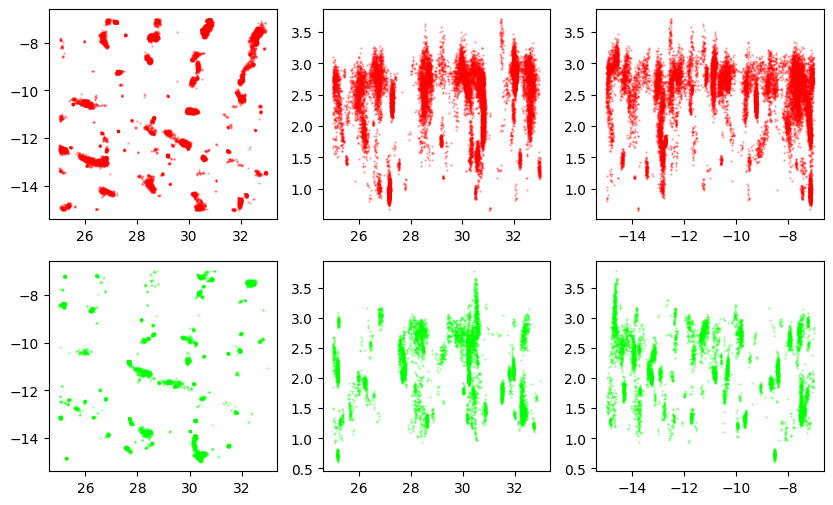

In [50]:
bbox = BoundingSquare(25, -15, side=8)
sq1 = {k: filter_bounded(v, bbox) for k, v in points_final.items()}

scatter_kwargs = {"alpha": 0.3, "s": 0.5}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1[protein][:, ax1],
            sq1[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )

In [52]:
len(sq1["desmin"])

19027

100%|██████████| 4000/4000 [00:04<00:00, 823.58it/s]


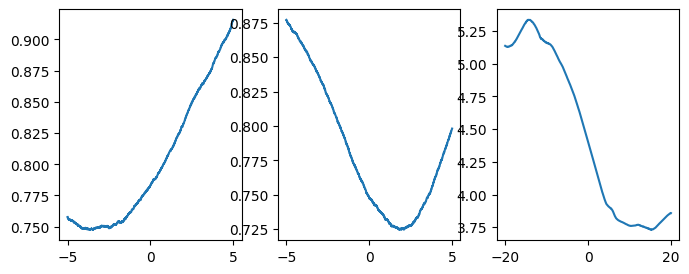

In [20]:
transform, metrics = calibrate_tilt(
    np.concatenate(list(sq1.values()), axis=0),
    np.arange(-5, 5, 0.001),
    np.arange(-20, 20, 0.01),
)
fig, axes = plt.subplots(1, len(metrics), figsize=(8, 3))
x_vals = (np.arange(-5, 5, 0.001), np.arange(-5, 5, 0.001), np.arange(-20, 20, 0.01))
for i, ax in enumerate(axes):
    ax.plot(x_vals[i], metrics[i])

sq2 = {k: transform(v) for k, v in sq1.items()}

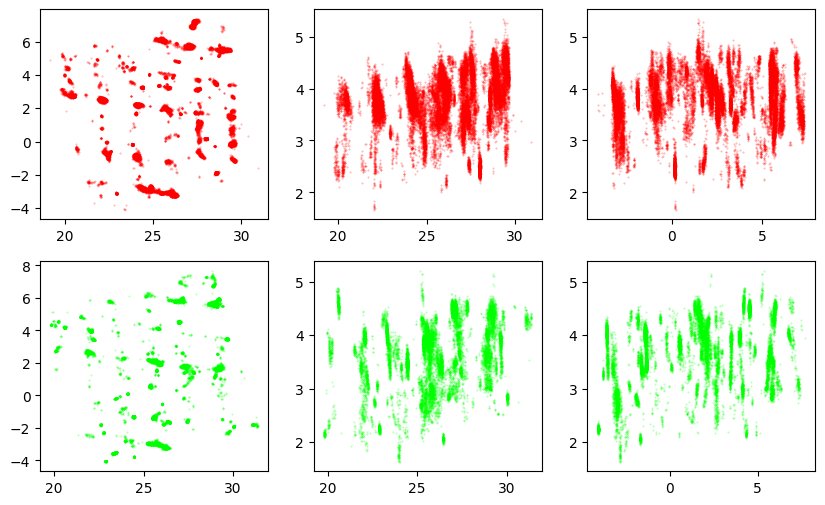

In [22]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq2[protein][:, ax1],
            sq2[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )

/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


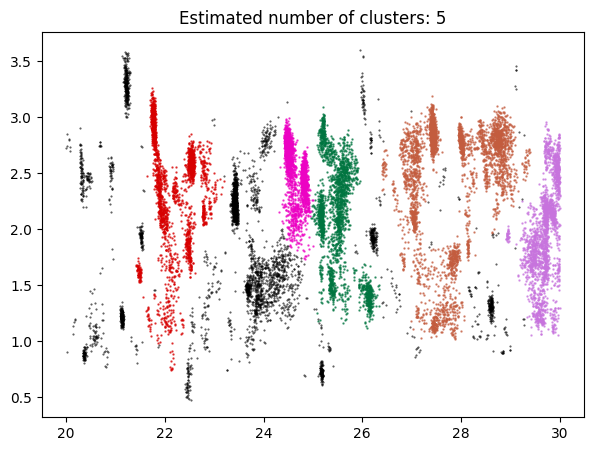

In [ ]:
clusterer = HDBSCAN(min_cluster_size=1500, min_samples=1)
xz = sq1["actinin"][:, np.array([0, 2])]
clusterer.fit(xz)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = clustered_scatterplot(ax, xz, clusterer.labels_)

In [35]:
transform, metric = find_optimal_clustering_angle(
    sq1["actinin"], np.arange(-20, 20, 0.05), min_cluster_size=1500, min_samples=1
)

  0%|          | 0/800 [00:00<?, ?it/s]/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/800 [00:00<03:19,  4.01it/s]/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed

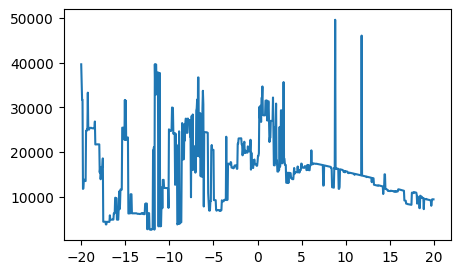

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(np.arange(-20, 20, 0.05), metric)
sq3 = {k: transform(v) for k, v in sq1.items()}

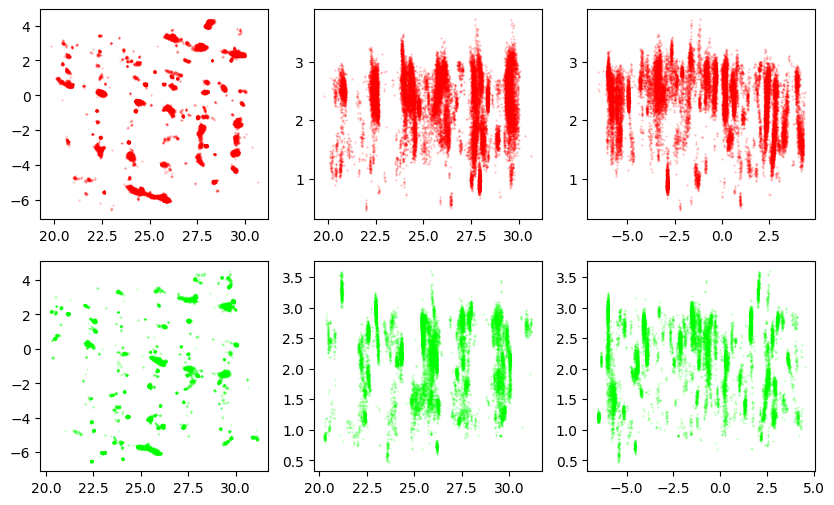

In [38]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq3[protein][:, ax1],
            sq3[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-2, 2, 0.001),
        rotation_sweep_values=np.arange(-15, 0, 0.1),
        min_cluster_size=200,
        min_samples=1,
    )

points_final = {k: transform_fn(v) for k, v in points.items()}


  5%|▍         | 7/150 [01:37<33:11, 13.93s/it]


KeyboardInterrupt: 